In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import scipy
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha
import ROOT
import xml.etree.ElementTree as ET


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


In [2]:
def readNumEvents(file):
    """
    Moderately efficent way to get the number of events stored in file.
    """
    
    with pylhe._extract_fileobj(file) as fileobj:
        nevts = sum(element.tag == "event" for event, element in ET.iterparse(fileobj, events=["end"]))
    return nevts

In [3]:
# inputFiles = {'axial on-shell' : '../../MG5/DMSimp_axial_med/Events/run_02/unweighted_events.lhe.gz',
#               'axial off-shell' : '../../MG5/DMSimp_axial_med/Events/run_03/unweighted_events.lhe.gz',
#               'vector on-shell' : '../../MG5/DMSimp_vector_med/Events/run_02/unweighted_events.lhe.gz',
#               'vector off-shell' : '../../MG5/DMSimp_vector_med/Events/run_03/unweighted_events.lhe.gz'}

# inputFiles = {'axial on-shell': '../../MG5/DMSimp_axial_parton/Events/run_01/unweighted_events.lhe.gz',
#               'axial off-shell': '../../MG5/DMSimp_axial_parton/Events/run_03/unweighted_events.lhe.gz',
#               'vector on-shell': '../../MG5/DMSimp_vector_parton/Events/run_01/unweighted_events.lhe.gz',
#               'vector off-shell': '../../MG5/DMSimp_vector_parton/Events/run_03/unweighted_events.lhe.gz',
#               'scalar on-shell': '../Tests/DMSimp_scalar_parton/Events/run_01/unweighted_events.lhe.gz',
#               'scalar off-shell': '../Tests/DMSimp_scalar_parton/Events/run_03/unweighted_events.lhe.gz',
#               'pseudoscalar on-shell': '../Tests/DMSimp_pseudoscalar_parton/Events/run_01/unweighted_events.lhe.gz',
#               'pseudoscalar off-shell': '../Tests/DMSimp_pseudoscalar_parton/Events/run_03/unweighted_events.lhe.gz'
#              }

# inputFiles = {'axial on-shell': '../DMSimp_axial_parton/Events/run_01/unweighted_events.lhe.gz',
#               'axial off-shell': '../DMSimp_axial_parton/Events/run_02/unweighted_events.lhe.gz',
#               'vector on-shell': '../DMSimp_vector_parton/Events/run_01/unweighted_events.lhe.gz',
#               'vector off-shell': '../DMSimp_vector_parton/Events/run_02/unweighted_events.lhe.gz',
#               'scalar on-shell': '../DMSimp_scalar_parton/Events/run_01/unweighted_events.lhe.gz',
#               'scalar off-shell': '../DMSimp_scalar_parton/Events/run_02/unweighted_events.lhe.gz',
#               'pseudoscalar on-shell': '../DMSimp_pseudoscalar_parton/Events/run_01/unweighted_events.lhe.gz',
#               'pseudoscalar off-shell': '../DMSimp_pseudoscalar_parton/Events/run_02/unweighted_events.lhe.gz'
#              }

inputFiles = {'axial on-shell': '../DMSimp_axial_parton/Events/run_03/unweighted_events.lhe.gz',
              'axial off-shell': '../DMSimp_axial_parton/Events/run_04/unweighted_events.lhe.gz',
              'vector on-shell': '../DMSimp_vector_parton/Events/run_03/unweighted_events.lhe.gz',
              'vector off-shell': '../DMSimp_vector_parton/Events/run_04/unweighted_events.lhe.gz',
              'scalar on-shell': '../DMSimp_scalar_parton/Events/run_03/unweighted_events.lhe.gz',
              'scalar off-shell': '../DMSimp_scalar_parton/Events/run_04/unweighted_events.lhe.gz',
              'pseudoscalar on-shell': '../DMSimp_pseudoscalar_parton/Events/run_03/unweighted_events.lhe.gz',
              'pseudoscalar off-shell': '../DMSimp_pseudoscalar_parton/Events/run_04/unweighted_events.lhe.gz'
             }

In [4]:
events = {}
nevents = {}
for label,f in inputFiles.items():   
    events[label] = pylhe.read_lhe_with_attributes(f)
    nevents[label] = readNumEvents(f)


In [5]:
parameters = {}
for label,file in inputFiles.items():
    banner = sorted(glob.glob(os.path.dirname(file)+'/*banner.txt'),key=os.path.getmtime,reverse=True)
    if len(banner) == 0:
        print('Banner not found for %s' %label)
    elif len(banner) > 1:        
        print('\n%i banner files found for %s. Using %s' 
              %(len(banner),label,os.path.basename(banner[0])))
    banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    if 55 in pars.blocks['MASS']:
        model = 'spin1'
        mMed = pars.blocks['MASS'][55]
    elif 54 in pars.blocks['MASS']:
        model = 'spin0'
        mMed = pars.blocks['MASS'][54]
        
    mDM = pars.blocks['MASS'][52]
    if model == 'spin1':
        gVq = pars.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
        gAq = pars.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
        gVx = pars.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
        gAx = pars.blocks['DMINPUTS'][3] # Mediator-DM axial coupling
    elif model == 'spin0':
        gVq = pars.blocks['DMINPUTS'][6] # Mediator-quark scalar coupling
        gAq = pars.blocks['DMINPUTS'][12] # Mediator-quark pseudoscalar coupling
        gVx = pars.blocks['DMINPUTS'][3] # Mediator-DM scalar coupling
        gAx = pars.blocks['DMINPUTS'][4] # Mediator-DM pseudoscalar coupling
        
        
    parameters[label] = {'mMed' : mMed, 'mDM' : mDM, 
                         'gVq' : gVq, 'gAq' : gAq, 'gVx' : gVx, 'gAx' : gAx}
    print(label,': mMed = %1.2f GeV, mDM = %1.2f GeV' %(mMed,mDM))

axial on-shell : mMed = 1000.00 GeV, mDM = 400.00 GeV
axial off-shell : mMed = 1000.00 GeV, mDM = 600.00 GeV
vector on-shell : mMed = 1000.00 GeV, mDM = 400.00 GeV
vector off-shell : mMed = 1000.00 GeV, mDM = 600.00 GeV
scalar on-shell : mMed = 1000.00 GeV, mDM = 400.00 GeV
scalar off-shell : mMed = 1000.00 GeV, mDM = 600.00 GeV

2 banner files found for pseudoscalar on-shell. Using run_01_pseudoscalar_1000_400_banner.txt
pseudoscalar on-shell : mMed = 1000.00 GeV, mDM = 400.00 GeV

2 banner files found for pseudoscalar off-shell. Using run_01_pseudoscalar_1000_600_banner.txt
pseudoscalar off-shell : mMed = 1000.00 GeV, mDM = 600.00 GeV


In [6]:
## jets
# pTj1min = 100.
# pTjmin = 25.
# etamax = 2.4
# ## MET
# minMET = 250.
# ## Electrons
# pTmin_el = 10.
# etamax_el = 2.5
# nMax_el = 0
# ## Muons
# pTmin_mu = 10.
# etamax_mu = 2.4
# nMax_mu = 0

In [7]:
pTj1 = {label : np.array([]) for label in inputFiles}
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
njets = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0 for label in inputFiles}

for label,evts in events.items():
   
    nevts = nevents[label]
    parameters[label]['Events'] = nevts
    
    for event in evts:

        particles = event.particles
       
        jets = [p for p in particles if abs(p.id) in [1,2,3,4,5,21] and p.status == 1]
#         med = [p for p in particles if abs(p.id) in [55] and p.status == 1]
        dm = [p for p in particles if abs(p.id) in [52] and p.status == 1]
#         electrons = [p for p in particles if abs(p.id) in [11] and p.status == 1]
#         muons = [p for p in particles if abs(p.id) in [13] and p.status == 1]
        
#         if len(med) != 1:
#             continue
        if len(dm) != 2:
            continue
            
        weight = event.eventinfo.weight/nevts
        totalweight[label] += weight
            
        # Filter jets
        jetList = []
        for j in jets:
            pT = np.sqrt(j.px**2+j.py**2)
            p = np.sqrt(j.px**2+j.py**2+j.pz**2)
#             pL = j.pz
#             eta = 0.5*np.log((p+pL)/(p-pL))
            
#             if pT < pTjmin:
#                 continue
#             if np.abs(eta) > etamax:
#                 continue
            jetList.append(j)
        jetList = sorted(jetList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)          
        
            
        # Filter electrons
#         electronList = []
#         for el in electrons:
#             pT = np.sqrt(el.px**2+el.py**2)
#             p = np.sqrt(el.px**2+el.py**2+el.pz**2)
#             pL = el.pz
#             eta = 0.5*np.log((p+pL)/(p-pL))
            
# #             if pT < pTmin_el:
# #                 continue
# #             if np.abs(eta) > etamax_el:
# #                 continue
#             electronList.append(el)
#         electronList = sorted(electronList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)                                    
        
        # Filter muons
#         muonList = []
#         for mu in muons:
#             pT = np.sqrt(mu.px**2+mu.py**2)
#             p = np.sqrt(mu.px**2+mu.py**2+mu.pz**2)
#             pL = mu.pz
#             eta = 0.5*np.log((p+pL)/(p-pL))
            
#             if pT < pTmin_mu:
#                 continue
#             if np.abs(eta) > etamax_mu:
#                 continue
#             muonList.append(mu)
#         muonList = sorted(muonList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)                                            
              
        # Compute MET
#         MET = np.sqrt((med[0].px)**2 + (med[0].py)**2)
        MET = np.sqrt((dm[0].px+dm[1].px)**2 + (dm[0].py+dm[1].py)**2)
        
        # Compute deltaPhi
#         if len(jetList) > 0:
#             phij1 = np.arctan2(jetList[0].py,jetList[0].px)
# #             phiMET = np.arctan2((med[0].py),(med[0].px))
#             phiMET = np.arctan2((dm[0].py+dm[1].py),(dm[0].px+dm[1].px))
#             deltaPhi = np.abs(phij1-phiMET)
#         else:
#             deltaPhi = 0.0
        
#         #Apply cuts:
#         if len(electronList) > 0:
#             continue
#         if len(muonList) > 0:
#             continue
#         if len(jetList) == 0:
#             continue
        
        pT1 = np.sqrt(jetList[0].px**2+jetList[0].py**2)
#         if MET < minMET:
#             continue
#         if pT1 < pTj1min:
#             continue
#         if deltaPhi < 0.5:
#             continue
        
        # Store relevant data        
        njets[label] = np.append(njets[label],len(jets))
        pTj1[label] = np.append(pTj1[label],pT1)
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label],MET)

In [8]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb' %w)
colors = {label : sns.color_palette('deep')[i+1] for i,label in enumerate(weights.keys())}    

axial on-shell total cross-section = 7.228e-01 pb
axial off-shell total cross-section = 3.603e-03 pb
vector on-shell total cross-section = 1.751e+00 pb
vector off-shell total cross-section = 1.797e-02 pb
scalar on-shell total cross-section = 6.920e-03 pb
scalar off-shell total cross-section = 2.808e-05 pb
pseudoscalar on-shell total cross-section = 1.809e-02 pb
pseudoscalar off-shell total cross-section = 1.501e-04 pb


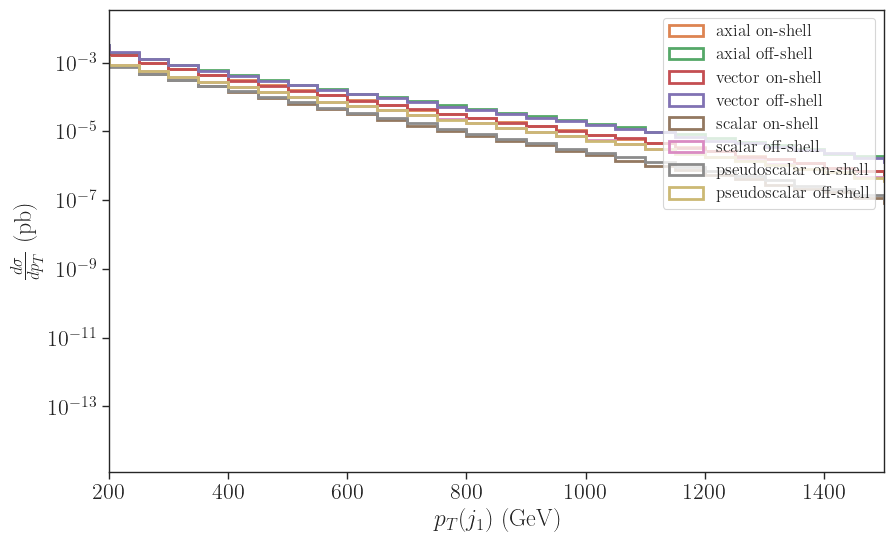

In [9]:
fig = plt.figure(figsize=(10,6))
for label,pt in pTj1.items():
#     if 'axial' in label:
    binc,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],
                               weights=weights[label],linewidth=2, density=True)
    errorc2,_ = np.histogram(pt,bins=binEdges,weights=weights[label]**2)
    errorc = np.sqrt(errorc2)
    binCenter = (binEdges[0:-1]+binEdges[1:])/2.
#     plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
#                  drawstyle = 'steps-mid',color=colors[label])

    
plt.yscale('log')
# plt.ylim(1e-8,10.)
plt.xlabel(r'$p_T(j_1)$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{dp_{T}}$ (pb)')
plt.xlim(200,1500)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

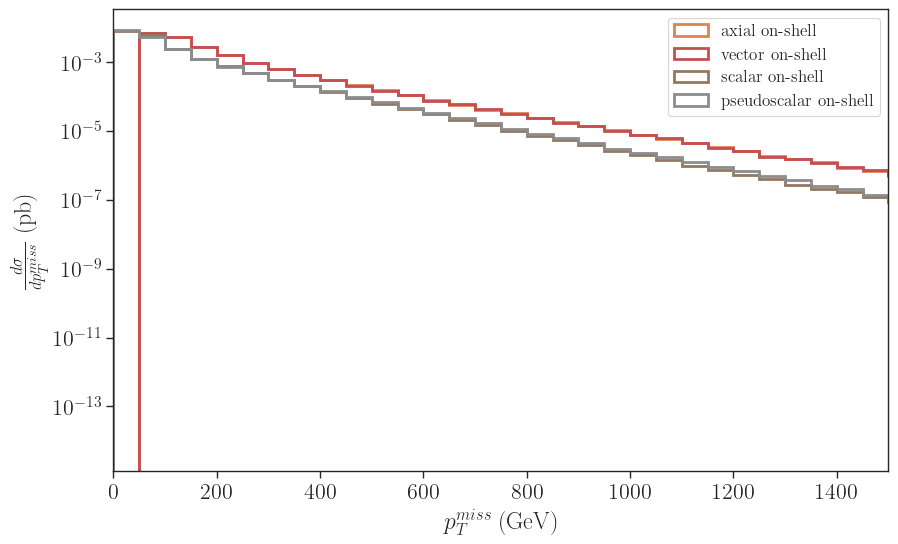

In [10]:
fig = plt.figure(figsize=(10,6))
for label,metPts in met.items():
    if 'on-shell' in label:
        binc,binEdges,patches = plt.hist(metPts,bins=np.linspace(0,5000,101),
                                   label=label,histtype='step',color=colors[label],
                                   weights=weights[label],linewidth=2, density=True)
        errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorc = np.sqrt(errorc2)
        binCenter = (binEdges[0:-1]+binEdges[1:])/2.
#         plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
#                      drawstyle = 'steps-mid',color=colors[label])

    
plt.yscale('log')
# plt.ylim(1e-8,1)
plt.xlabel(r'$p_T^{miss}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb)')
plt.xlim(0,1500)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

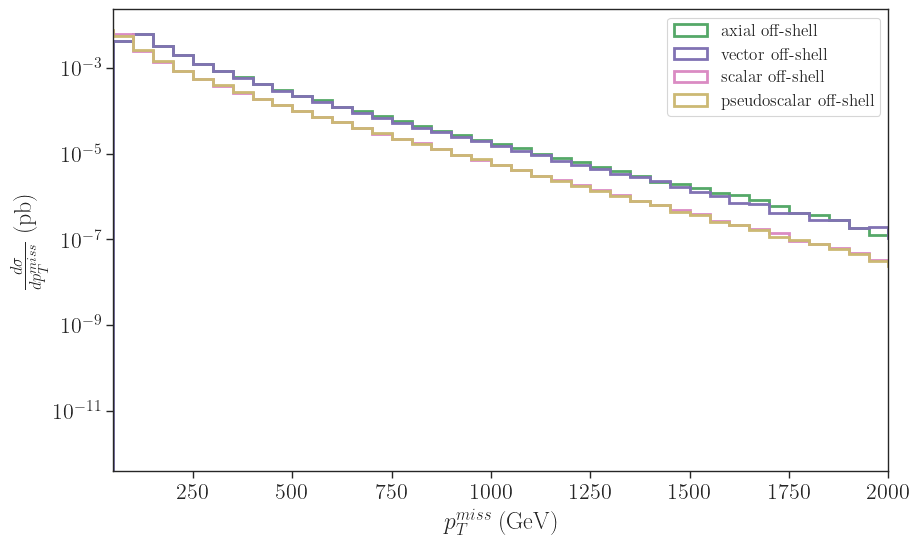

In [14]:
fig = plt.figure(figsize=(10,6))
for label,metPts in met.items():
    if 'off-shell' in label:
        binc,binEdges,patches = plt.hist(metPts,bins=np.linspace(0,5000,101),
                                   label=label,histtype='step',color=colors[label],
                                   weights=weights[label],linewidth=2,density=True)
        errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorc = np.sqrt(errorc2)
        binCenter = (binEdges[0:-1]+binEdges[1:])/2.
#         plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
#                      drawstyle = 'steps-mid',color=colors[label])

    
plt.yscale('log')
# plt.ylim(1e-3,1)
plt.xlabel(r'$p_T^{miss}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb)')
plt.xlim(50,2000)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()